In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [39]:
# Load the datasets
train_df = pd.read_csv('Data/btc_2012-2023_train.csv')
test_df = pd.read_csv('Data/btc_2024.csv')

In [40]:
train_df.head(5)

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %,day_of_year,score
0,0,2023-12-31,"42,272.5","42,141.6","42,878.8","41,971.4",35.58K,0.32%,365,0.245098
1,1,2023-12-30,"42,136.7","42,074.7","42,592.2","41,527.3",35.18K,0.15%,364,0.260478
2,2,2023-12-29,"42,072.4","42,581.1","43,108.0","41,459.0",60.98K,-1.19%,363,0.228885
3,3,2023-12-28,"42,581.1","43,446.5","43,782.6","42,309.3",49.84K,-1.99%,362,0.235345
4,4,2023-12-27,"43,446.5","42,514.3","43,676.7","42,115.3",50.10K,2.20%,361,0.218655


In [41]:
test_df.head(5)

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %,day_of_year,score
0,0,2024-06-16,"66,132.2","66,223.0","66,259.3","66,071.1",21.31K,-0.14%,168,0.242048
1,1,2024-06-15,"66,223.0","66,034.1","66,446.4","65,895.1",24.05K,0.29%,167,0.310672
2,2,2024-06-14,"66,034.8","66,775.2","67,347.7","65,076.5",65.18K,-1.11%,166,0.266349
3,3,2024-06-13,"66,773.1","68,260.6","68,384.6","66,324.3",66.36K,-2.18%,165,0.320453
4,4,2024-06-12,"68,260.1","67,320.9","69,990.8","66,911.5",85.55K,1.40%,164,0.234674


In [42]:
# Convert 'Date' to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Remove commas and convert to float
train_df['Price'] = train_df['Price'].str.replace(',', '').astype(float)
test_df['Price'] = test_df['Price'].str.replace(',', '').astype(float)

# Convert relevant columns to appropriate formats
train_df['Open'] = train_df['Open'].str.replace(',', '').astype(float)
train_df['High'] = train_df['High'].str.replace(',', '').astype(float)
train_df['Low'] = train_df['Low'].str.replace(',', '').astype(float)
train_df['Vol.'] = train_df['Vol.'].str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9').astype(float)
train_df['Change %'] = train_df['Change %'].str.replace('%', '').astype(float) / 100

test_df['Open'] = test_df['Open'].str.replace(',', '').astype(float)
test_df['High'] = test_df['High'].str.replace(',', '').astype(float)
test_df['Low'] = test_df['Low'].str.replace(',', '').astype(float)
test_df['Vol.'] = test_df['Vol.'].str.replace('K', 'e3').str.replace('M', 'e6').str.replace('B', 'e9').astype(float)
test_df['Change %'] = test_df['Change %'].str.replace('%', '').astype(float) / 100

In [43]:
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'day_of_year', 'score']

In [44]:
# Check for NaN values and handle them
train_df[features] = train_df[features].fillna(method='ffill').fillna(method='bfill')
test_df[features] = test_df[features].fillna(method='ffill').fillna(method='bfill')

In [45]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

In [46]:
print(train_scaled.shape)
print(train_scaled)

(4383, 8)
[[6.25977249e-01 6.24031278e-01 6.21492414e-01 ... 1.45996701e-01
  9.97260274e-01 5.03739785e-01]
 [6.23966104e-01 6.23040526e-01 6.17337960e-01 ... 1.45565284e-01
  9.94520548e-01 5.76413048e-01]
 [6.23013846e-01 6.30540026e-01 6.24814818e-01 ... 1.42164700e-01
  9.91780822e-01 4.27124573e-01]
 ...
 [1.03667305e-05 1.48094395e-05 1.30460875e-05 ... 1.28663875e-01
  5.47945205e-03 6.01903380e-01]
 [1.48096150e-05 1.62903835e-05 1.59452180e-05 ... 1.42773760e-01
  2.73972603e-03 2.39185553e-01]
 [1.62905765e-05 7.40471977e-06 1.59452180e-05 ... 1.74749397e-01
  0.00000000e+00 5.35595692e-01]]


In [47]:
# Debug: Print initial and final few rows of the scaled data
print("First few rows of scaled training data:")
print(train_scaled[:5])
print("Last few rows of scaled training data:")
print(train_scaled[-5:])

First few rows of scaled training data:
[[6.25977249e-01 6.24031278e-01 6.21492414e-01 6.32698135e-01
  7.90156646e-06 1.45996701e-01 9.97260274e-01 5.03739785e-01]
 [6.23966104e-01 6.23040526e-01 6.17337960e-01 6.26002925e-01
  7.81208099e-06 1.45565284e-01 9.94520548e-01 5.76413048e-01]
 [6.23013846e-01 6.30540026e-01 6.24814818e-01 6.24973240e-01
  1.35838934e-05 1.42164700e-01 9.91780822e-01 4.27124573e-01]
 [6.30547497e-01 6.43356115e-01 6.34593585e-01 6.37792284e-01
  1.10917232e-05 1.40134501e-01 9.89041096e-01 4.57650087e-01]
 [6.43363737e-01 6.29550756e-01 6.33058496e-01 6.34867558e-01
  1.11498888e-05 1.50767669e-01 9.86301370e-01 3.78783111e-01]]
Last few rows of scaled training data:
[[3.99859605e-05 2.07332154e-05 4.05878277e-05 2.56290422e-05
  4.07315460e-05 2.08070042e-01 1.09589041e-02 3.72350845e-01]
 [2.07334610e-05 1.03666077e-05 1.88443486e-05 1.35683165e-05
  2.92863552e-05 1.81068392e-01 8.21917808e-03 2.17645786e-01]
 [1.03667305e-05 1.48094395e-05 1.30460875e-0

In [48]:
# Function to create sequences for the LSTM/GRU model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 60

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [49]:
# Check for NaN or Infinite values
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(y_train))
assert not np.any(np.isnan(X_test))
assert not np.any(np.isnan(y_test))
assert not np.any(np.isinf(X_train))
assert not np.any(np.isinf(y_train))
assert not np.any(np.isinf(X_test))
assert not np.any(np.isinf(y_test))

In [50]:
# Define the LSTM + GRU model
class LSTMGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMGRUModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out, _ = self.gru(out)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
num_layers = 1
num_epochs = 50
learning_rate = 0.0001
batch_size = 32

In [52]:
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)


In [53]:
# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [54]:
# Initialize the model, loss function, and optimizer
model = LSTMGRUModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


In [56]:
# Train the model
for epoch in range(num_epochs):
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        epoch_losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
    
    avg_epoch_loss = np.mean(epoch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.10f}')

Epoch [1/50], Loss: 0.0413077915
Epoch [2/50], Loss: 0.0047470044
Epoch [3/50], Loss: 0.0019763024
Epoch [4/50], Loss: 0.0017187943
Epoch [5/50], Loss: 0.0014825600
Epoch [6/50], Loss: 0.0014319277
Epoch [7/50], Loss: 0.0013611630
Epoch [8/50], Loss: 0.0012636723
Epoch [9/50], Loss: 0.0011802410
Epoch [10/50], Loss: 0.0010283144
Epoch [11/50], Loss: 0.0010046654
Epoch [12/50], Loss: 0.0009384375
Epoch [13/50], Loss: 0.0008946055
Epoch [14/50], Loss: 0.0008953677
Epoch [15/50], Loss: 0.0008737824
Epoch [16/50], Loss: 0.0008545141
Epoch [17/50], Loss: 0.0007738627
Epoch [18/50], Loss: 0.0008604944
Epoch [19/50], Loss: 0.0007169129
Epoch [20/50], Loss: 0.0006920595
Epoch [21/50], Loss: 0.0006924733
Epoch [22/50], Loss: 0.0006771538
Epoch [23/50], Loss: 0.0006746416
Epoch [24/50], Loss: 0.0006166646
Epoch [25/50], Loss: 0.0006435368
Epoch [26/50], Loss: 0.0005901440
Epoch [27/50], Loss: 0.0005963227
Epoch [28/50], Loss: 0.0005907852
Epoch [29/50], Loss: 0.0005346851
Epoch [30/50], Loss: 0.

In [57]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).cpu().numpy()
    y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
    y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]


In [59]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAPE: {mape:.4f}')

RMSE: 2222.8131, MSE: 4940898.0797, MAPE: 0.0289


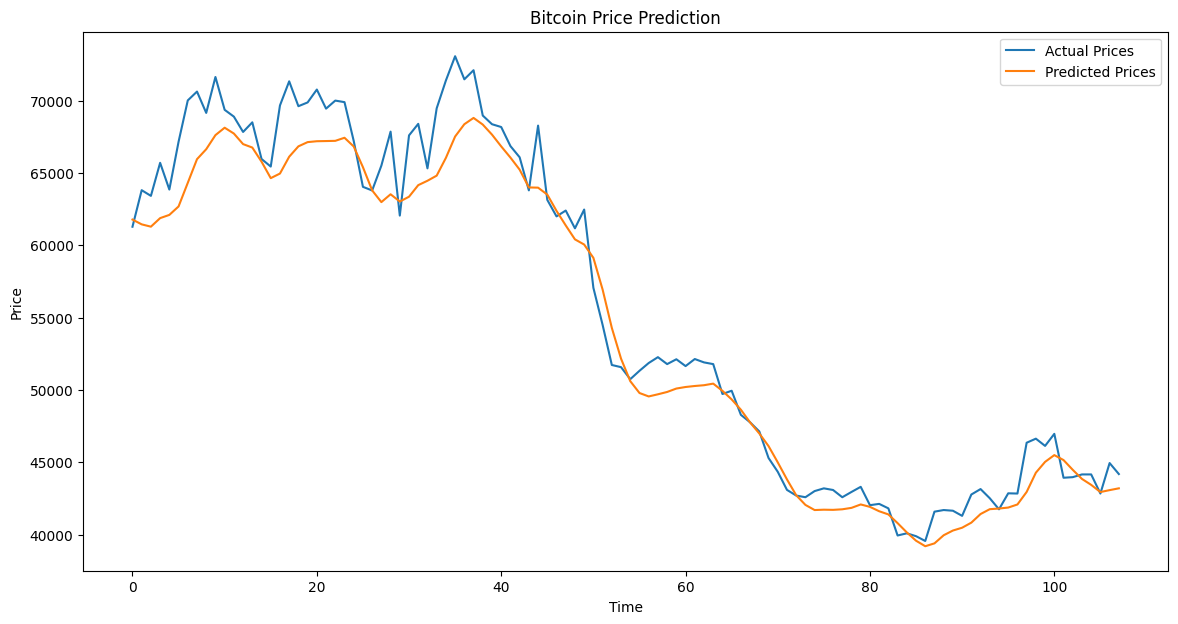

In [60]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [61]:
# Define the LSTM and GRU models
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [62]:
# Initialize the models, loss function, and optimizer
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
gru_model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)

criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

In [63]:
# Train the LSTM model
for epoch in range(num_epochs):
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        lstm_model.train()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        epoch_losses.append(loss.item())
        
        lstm_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        lstm_optimizer.step()
    
    avg_epoch_loss = np.mean(epoch_losses)
    print(f'LSTM Model Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.10f}')

LSTM Model Epoch [1/50], Loss: 0.0649675833
LSTM Model Epoch [2/50], Loss: 0.0157545861
LSTM Model Epoch [3/50], Loss: 0.0034976390
LSTM Model Epoch [4/50], Loss: 0.0027317914
LSTM Model Epoch [5/50], Loss: 0.0024361103
LSTM Model Epoch [6/50], Loss: 0.0021869943
LSTM Model Epoch [7/50], Loss: 0.0021587924
LSTM Model Epoch [8/50], Loss: 0.0020536806
LSTM Model Epoch [9/50], Loss: 0.0018589197
LSTM Model Epoch [10/50], Loss: 0.0016776024
LSTM Model Epoch [11/50], Loss: 0.0016813703
LSTM Model Epoch [12/50], Loss: 0.0015515422
LSTM Model Epoch [13/50], Loss: 0.0015233087
LSTM Model Epoch [14/50], Loss: 0.0016096499
LSTM Model Epoch [15/50], Loss: 0.0013377811
LSTM Model Epoch [16/50], Loss: 0.0014208599
LSTM Model Epoch [17/50], Loss: 0.0013312761
LSTM Model Epoch [18/50], Loss: 0.0012920977
LSTM Model Epoch [19/50], Loss: 0.0012307289
LSTM Model Epoch [20/50], Loss: 0.0011469148
LSTM Model Epoch [21/50], Loss: 0.0011446747
LSTM Model Epoch [22/50], Loss: 0.0010417633
LSTM Model Epoch [2

In [64]:
# Train the GRU model
for epoch in range(num_epochs):
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        gru_model.train()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        epoch_losses.append(loss.item())
        
        gru_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(gru_model.parameters(), max_norm=1.0)
        gru_optimizer.step()
    
    avg_epoch_loss = np.mean(epoch_losses)
    print(f'GRU Model Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.10f}')

GRU Model Epoch [1/50], Loss: 0.0465078788
GRU Model Epoch [2/50], Loss: 0.0129550713
GRU Model Epoch [3/50], Loss: 0.0024902810
GRU Model Epoch [4/50], Loss: 0.0021440294
GRU Model Epoch [5/50], Loss: 0.0019032015
GRU Model Epoch [6/50], Loss: 0.0016405558
GRU Model Epoch [7/50], Loss: 0.0015540824
GRU Model Epoch [8/50], Loss: 0.0014271350
GRU Model Epoch [9/50], Loss: 0.0014162382
GRU Model Epoch [10/50], Loss: 0.0013203288
GRU Model Epoch [11/50], Loss: 0.0010948219
GRU Model Epoch [12/50], Loss: 0.0010392067
GRU Model Epoch [13/50], Loss: 0.0009900878
GRU Model Epoch [14/50], Loss: 0.0010014230
GRU Model Epoch [15/50], Loss: 0.0008580319
GRU Model Epoch [16/50], Loss: 0.0009324860
GRU Model Epoch [17/50], Loss: 0.0007496409
GRU Model Epoch [18/50], Loss: 0.0007255831
GRU Model Epoch [19/50], Loss: 0.0007301135
GRU Model Epoch [20/50], Loss: 0.0006947062
GRU Model Epoch [21/50], Loss: 0.0006851320
GRU Model Epoch [22/50], Loss: 0.0006613563
GRU Model Epoch [23/50], Loss: 0.00069428

In [65]:
# Evaluate the models and combine their predictions
lstm_model.eval()
gru_model.eval()

with torch.no_grad():
    y_pred_lstm = lstm_model(X_test_torch).cpu().numpy()
    y_pred_gru = gru_model(X_test_torch).cpu().numpy()

# Average the predictions from the LSTM and GRU models
y_pred_ensemble = (y_pred_lstm + y_pred_gru) / 2

# Inverse transform the predictions to the original scale
y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred_ensemble, np.zeros((y_pred_ensemble.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

In [66]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAPE: {mape:.4f}')


RMSE: 1826.4708, MSE: 3335995.5305, MAPE: 0.0235


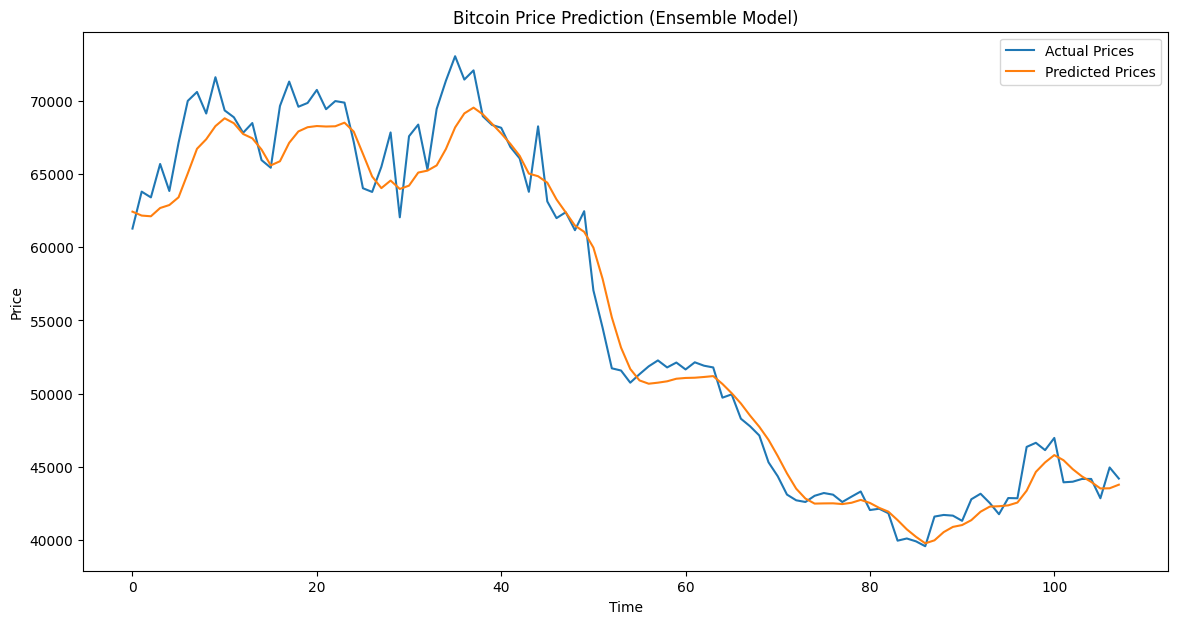

In [67]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bitcoin Price Prediction (Ensemble Model)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

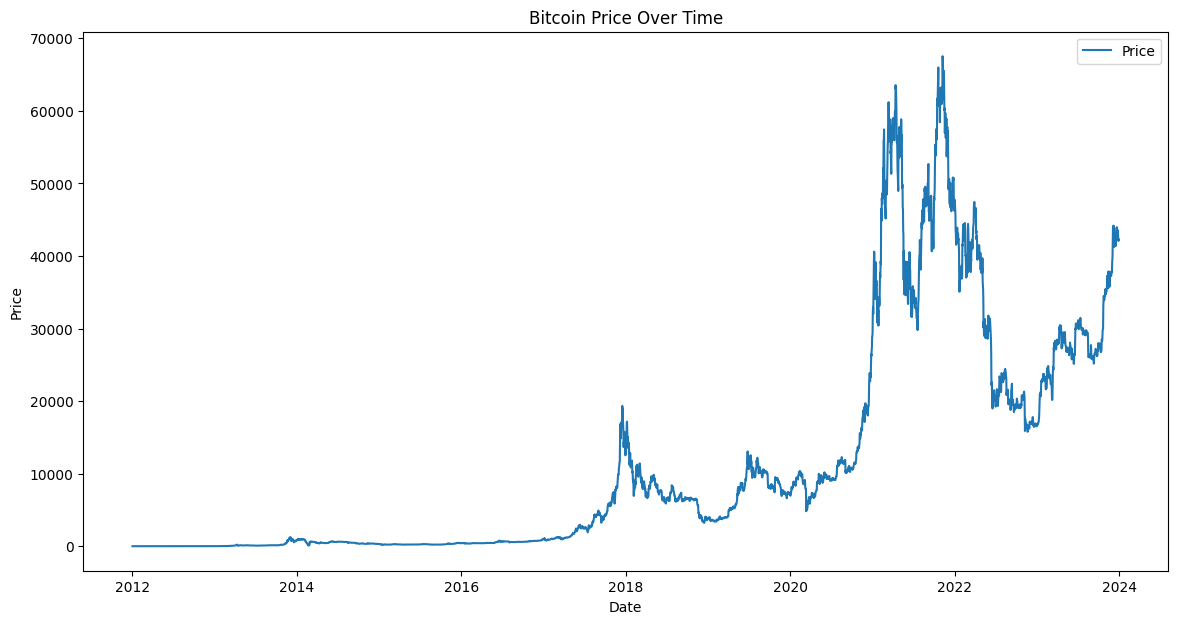

In [68]:
# Function to plot the data to visualize outliers
def plot_data_with_outliers(data, feature, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data[feature], label=feature)
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot the 'Price' feature to visualize outliers
plot_data_with_outliers(train_df, 'Price', 'Bitcoin Price Over Time')

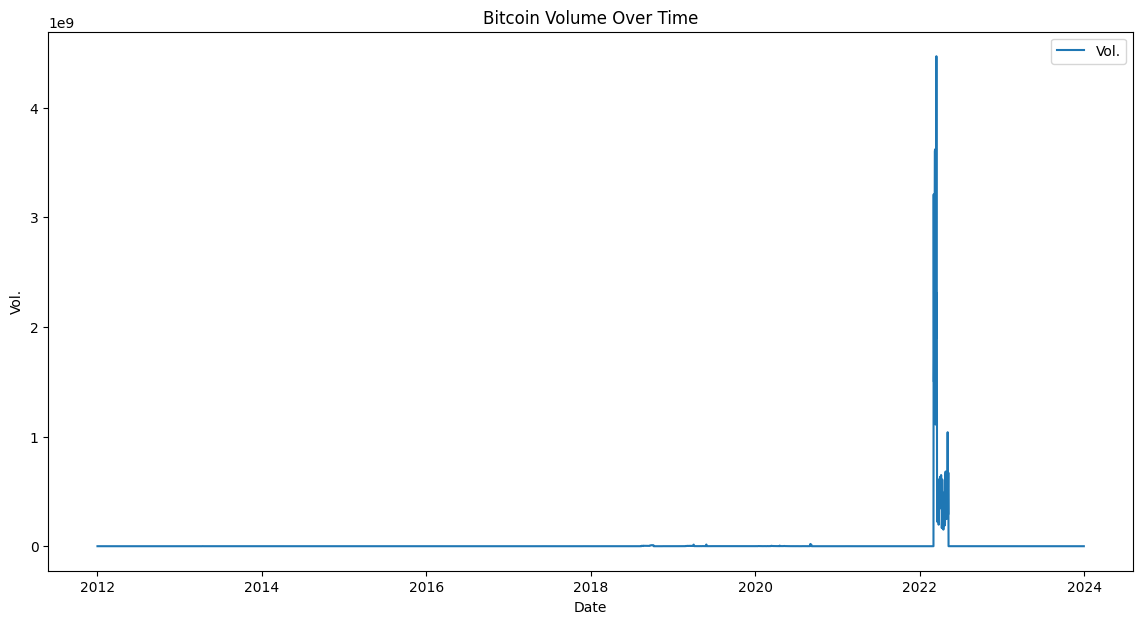

In [69]:
# Plot the 'Vol.' feature to visualize outliers
plot_data_with_outliers(train_df, 'Vol.', 'Bitcoin Volume Over Time')

In [73]:
from scipy import stats

# Identify and handle outliers using z-score method
def identify_outliers(df, features):
    z_scores = np.abs(stats.zscore(df[features]))
    outliers = df[(z_scores > 3).any(axis=1)]
    return outliers

outliers = identify_outliers(train_df, features)
print("Outliers identified and removed:")
print(outliers)

Outliers identified and removed:
      Unnamed: 0       Date    Price     Open     High      Low      Vol.  \
217          217 2023-05-28  28071.2  26855.3  28181.9  26788.5   55230.0   
220          220 2023-05-25  26475.8  26327.1  26589.2  25892.5   50170.0   
223          223 2023-05-22  26847.3  26749.9  27048.9  26546.1   35560.0   
417          417 2022-11-09  15886.9  18538.9  18583.8  15603.3  869570.0   
566          566 2022-06-13  22448.0  26606.3  26857.6  22006.3  379260.0   
...          ...        ...      ...      ...      ...      ...       ...   
4241        4241 2012-05-21      5.1      5.1      5.1      5.1   33620.0   
4329        4329 2012-02-23      5.0      4.4      5.2      4.4  164310.0   
4338        4338 2012-02-14      4.5      5.3      5.4      4.2  297570.0   
4366        4366 2012-01-17      5.6      6.7      6.9      4.6  213410.0   
4379        4379 2012-01-04      5.6      4.9      5.7      4.8  131170.0   

      Change %  day_of_year     score  
21

In [74]:
# Remove the identified outliers
train_df = train_df.drop(outliers.index)

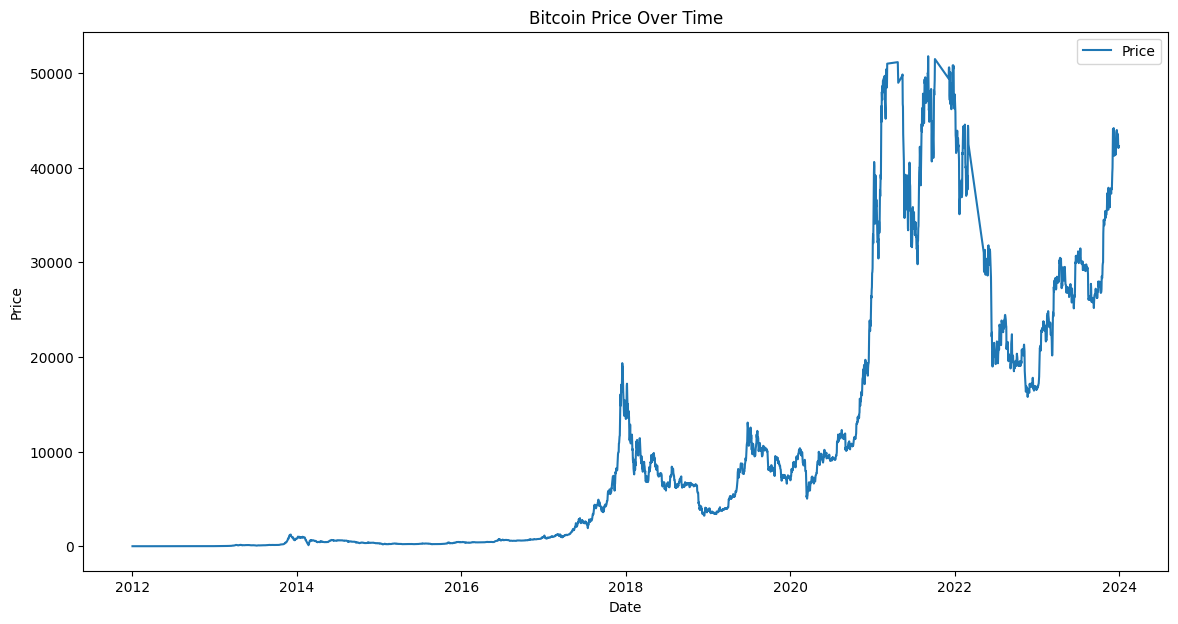

In [75]:
# Plot the 'Price' feature to visualize outliers
plot_data_with_outliers(train_df, 'Price', 'Bitcoin Price Over Time')

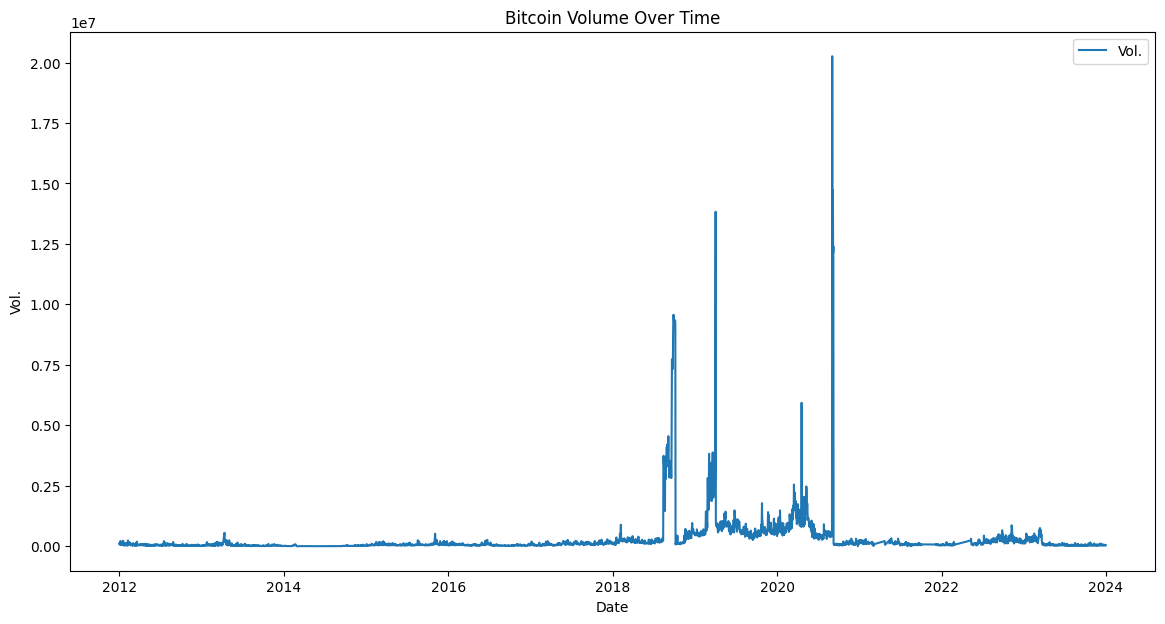

In [76]:
# Plot the 'Vol.' feature to visualize outliers
plot_data_with_outliers(train_df, 'Vol.', 'Bitcoin Volume Over Time')

In [77]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

# Function to create sequences for the models
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 60

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [78]:
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [79]:
# Train the LSTM model
for epoch in range(num_epochs):
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        lstm_model.train()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        epoch_losses.append(loss.item())
        
        lstm_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        lstm_optimizer.step()
    
    avg_epoch_loss = np.mean(epoch_losses)
    print(f'LSTM Model Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.10f}')

LSTM Model Epoch [1/50], Loss: 0.0008454056
LSTM Model Epoch [2/50], Loss: 0.0007232024
LSTM Model Epoch [3/50], Loss: 0.0007635231
LSTM Model Epoch [4/50], Loss: 0.0008615797
LSTM Model Epoch [5/50], Loss: 0.0007135956
LSTM Model Epoch [6/50], Loss: 0.0006585727
LSTM Model Epoch [7/50], Loss: 0.0007642372
LSTM Model Epoch [8/50], Loss: 0.0007010362
LSTM Model Epoch [9/50], Loss: 0.0007419218
LSTM Model Epoch [10/50], Loss: 0.0006743654
LSTM Model Epoch [11/50], Loss: 0.0007270221
LSTM Model Epoch [12/50], Loss: 0.0006370662
LSTM Model Epoch [13/50], Loss: 0.0007145159
LSTM Model Epoch [14/50], Loss: 0.0006460871
LSTM Model Epoch [15/50], Loss: 0.0006652562
LSTM Model Epoch [16/50], Loss: 0.0006609245
LSTM Model Epoch [17/50], Loss: 0.0005811043
LSTM Model Epoch [18/50], Loss: 0.0006464656
LSTM Model Epoch [19/50], Loss: 0.0006463940
LSTM Model Epoch [20/50], Loss: 0.0006159909
LSTM Model Epoch [21/50], Loss: 0.0006113524
LSTM Model Epoch [22/50], Loss: 0.0005851859
LSTM Model Epoch [2

In [80]:
# Train the GRU model
for epoch in range(num_epochs):
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        gru_model.train()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        epoch_losses.append(loss.item())
        
        gru_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(gru_model.parameters(), max_norm=1.0)
        gru_optimizer.step()
    
    avg_epoch_loss = np.mean(epoch_losses)
    print(f'GRU Model Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.10f}')

GRU Model Epoch [1/50], Loss: 0.0006740544
GRU Model Epoch [2/50], Loss: 0.0005391777
GRU Model Epoch [3/50], Loss: 0.0005239432
GRU Model Epoch [4/50], Loss: 0.0005474794
GRU Model Epoch [5/50], Loss: 0.0005009503
GRU Model Epoch [6/50], Loss: 0.0005141948
GRU Model Epoch [7/50], Loss: 0.0005231083
GRU Model Epoch [8/50], Loss: 0.0004887827
GRU Model Epoch [9/50], Loss: 0.0004821634
GRU Model Epoch [10/50], Loss: 0.0004766787
GRU Model Epoch [11/50], Loss: 0.0004656343
GRU Model Epoch [12/50], Loss: 0.0005182338
GRU Model Epoch [13/50], Loss: 0.0005343197
GRU Model Epoch [14/50], Loss: 0.0004797421
GRU Model Epoch [15/50], Loss: 0.0004923530
GRU Model Epoch [16/50], Loss: 0.0004659010
GRU Model Epoch [17/50], Loss: 0.0004512275
GRU Model Epoch [18/50], Loss: 0.0004100023
GRU Model Epoch [19/50], Loss: 0.0004964714
GRU Model Epoch [20/50], Loss: 0.0004650343
GRU Model Epoch [21/50], Loss: 0.0004643995
GRU Model Epoch [22/50], Loss: 0.0004483607
GRU Model Epoch [23/50], Loss: 0.00046603

In [83]:
# Evaluate the models and combine their predictions
lstm_model.eval()
gru_model.eval()

with torch.no_grad():
    y_pred_lstm = lstm_model(X_test_torch).cpu().numpy()
    y_pred_gru = gru_model(X_test_torch).cpu().numpy()

# Average the predictions from the LSTM and GRU models
y_pred_ensemble = (y_pred_lstm + y_pred_gru) / 2

# Inverse transform the predictions to the original scale
y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_pred_inverse = scaler.inverse_transform(np.concatenate((y_pred_ensemble, np.zeros((y_pred_ensemble.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAPE: {mape:.4f}')

RMSE: 1237.1108, MSE: 1530443.2515, MAPE: 0.0134


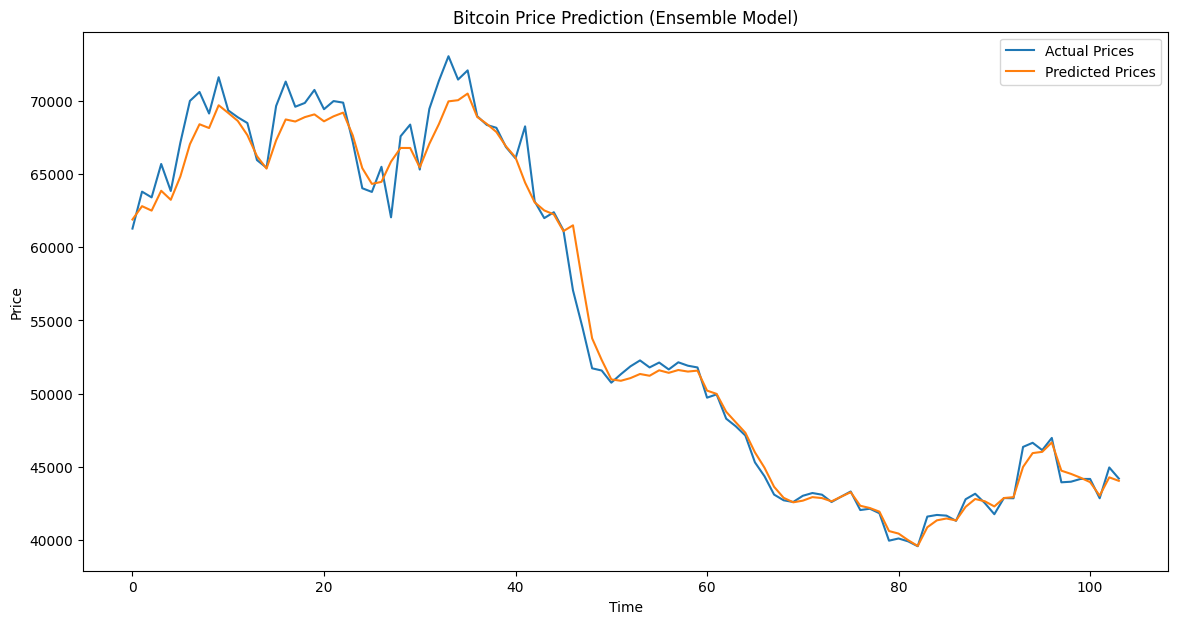

In [84]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bitcoin Price Prediction (Ensemble Model)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()